# **Data preparation and visualisation**

### Objectives

- **Answering business requirement 1:**
    * The client requires that the dataset are studied and results are visualised.

### Inputs

- inputs/dataset/raw/flower_photos

### Outputs

- inputs/dataset/raw/flower_photos/train<br>
- inputs/dataset/raw/flower_photos/validation<br>
- inputs/dataset/raw/flower_photos/test<br>
- Color differences between all images<br>


## **Install Requirements and Prepare Workspace**

### Workspace setup

First let see that we are working from the correct directory that should be "flowers_CNN".<br>
By default the working directory is "..../flowers_CNN/jupyter_notebook"

In [1]:
import os
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\Flower-bingo\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


By running the cell below the working directory will be the parent directory of the cell above

In [2]:
os.chdir(os.path.dirname(working_dir))

new_working_dir = os.getcwd()
print(f"You have now changed your working directory to {new_working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\Flower-bingo\flowers_CNN


### Set output destination

In [3]:
version = 'v8'
file_path = f'outputs/{version}'
current_working_dir = os.getcwd()

if 'outputs' in os.listdir(current_working_dir) and version in os.listdir(current_working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path, exist_ok=True)

This version already exists, create a new version if you are working on a new version


### Import packages

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import shutil
import random
import cv2

### Split into train/validation/test sets

In [7]:
def split_train_validation_test_images(image_dir, train_set_ratio, validation_set_ratio, test_set_ratio):
    """
    Splits the images in a given directory into training, validation, and test sets based on the provided ratios.

    This function:
    - Checks if the total of the provided ratios for the train, validation, and test sets is 1.0.
    - Creates 'train', 'validation', and 'test' directories (if they don't already exist) within the given image directory.
    - Organizes the image files for each flower category into these subdirectories according to the specified ratios.
    - Moves images into their respective folders: 'train', 'validation', and 'test', based on the specified ratios.
    - Deletes the original category folders if they are empty after moving the files.

    Parameters:
    -----------
    image_dir : str
        The path to the directory containing flower subfolders with image files.
    
    train_set_ratio : float
        The ratio of images to be used for the training set (should be a float between 0 and 1).
    
    validation_set_ratio : float
        The ratio of images to be used for the validation set (should be a float between 0 and 1).
    
    test_set_ratio : float
        The ratio of images to be used for the test set (should be a float between 0 and 1).

    
    Raises:
    -------
    ValueError
        If the sum of `train_set_ratio`, `validation_set_ratio`, and `test_set_ratio` is not equal to 1.0.
    """
    
    # Check if the ratios are set to the correct total amount
    if train_set_ratio + validation_set_ratio + test_set_ratio != 1.0:
        print("The total of train_set_ratio, validation_set_ratio and test_set_ratio should be 1.0")
        return

    flowers = os.listdir(image_dir)
    
    # Create 'train', 'validation', and 'test' directories if they don't exist
    for folder in ['train', 'validation', 'test']:
        folder_path = os.path.join(image_dir, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        for flower in flowers:
            flower_folder_path = os.path.join(folder_path, flower)
            os.makedirs(flower_folder_path, exist_ok=True)

    # Move images to the appropriate sub-folder based on the ratios
    for flower in flowers:
        files = os.listdir(os.path.join(image_dir, flower))
        random.shuffle(files)

        train_set_files_qty = int(len(files) * train_set_ratio)
        validation_set_files_qty = int(len(files) * validation_set_ratio)

        count = 1
        for image_name in files:
            src_path = os.path.join(image_dir, flower, image_name)
            if count <= train_set_files_qty:
                dest_path = os.path.join(image_dir, 'train', flower, image_name)
            elif count <= (train_set_files_qty + validation_set_files_qty):
                dest_path = os.path.join(image_dir, 'validation', flower, image_name)
            else:
                dest_path = os.path.join(image_dir, 'test', flower, image_name)
            
            shutil.move(src_path, dest_path)
            count += 1

        # Delete the source folder after moving the images
        os.rmdir(os.path.join(image_dir, flower))

Calls the split function with ratio parameters

In [8]:
split_train_validation_test_images(image_dir="inputs/dataset/raw/flower_photos",
                                   train_set_ratio=0.7,
                                   validation_set_ratio=0.1,
                                   test_set_ratio=0.2
                                   )

## **Data visualization**

This function will go through all set folders and visualizing a barplot with the result

In [19]:
def distribution_between_sets(image_dirs):
    """
    This function calculates and visualizes the distribution of images across 
    the train, validation, and test sets for each label (flower category).

    The function:
    1. Iterates over each set ('train', 'validation', 'test') and each label in the dataset.
    2. Counts the number of images for each label in each set.
    3. Creates a barplot to visualize the distribution of images across the sets.
    
    Parameters:
    - image_dirs: The directory containing the train, validation, and test sets, organized by label (flower category).
    
    Returns:
    - A seaborn barplot showing the distribution of images across the sets for each label.
    """
    
    # Get list of labels (flower categories) from the 'train' directory
    train_dir = os.path.join(image_dirs, 'train')
    labels = os.listdir(train_dir)  # Get the labels from the 'train' folder

    data = []  # List to store distribution data

    # Loop through the set folders (train, validation, test)
    for folder in ['train', 'validation', 'test']:
        for label in labels:
            # Generate the full path to the label directory for each set
            folder_label_path = os.path.join(image_dirs, folder, label)

            # Check if the folder exists
            if os.path.exists(folder_label_path):
                # Count the number of images in this folder
                image_count = len(os.listdir(folder_label_path))
            else:
                # If the folder doesn't exist, set count to 0
                image_count = 0
                print(f"Warning: {folder_label_path} does not exist!")

            # Append the result to the data list
            data.append({
                'Set': folder,
                'Label': label,
                'Frequency': image_count
            })
            print(f"* {folder} - {label}: {image_count} images")

    # Convert the data list into a pandas DataFrame
    df_freq = pd.DataFrame(data)

    # Create a seaborn barplot
    print("\n")
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
    
    # Save the plot as a PNG image
    plt.savefig(f'{file_path}/labels_distribution_sets.png', bbox_inches='tight', dpi=150)
    plt.show()


Call the function with path to image folder

* train - daisy: 3544 images
* train - dandelion: 5028 images
* train - roses: 3589 images
* train - sunflowers: 3914 images
* train - tulips: 4474 images
* validation - daisy: 506 images
* validation - dandelion: 718 images
* validation - roses: 512 images
* validation - sunflowers: 559 images
* validation - tulips: 639 images
* test - daisy: 1014 images
* test - dandelion: 1438 images
* test - roses: 1027 images
* test - sunflowers: 1119 images
* test - tulips: 1279 images




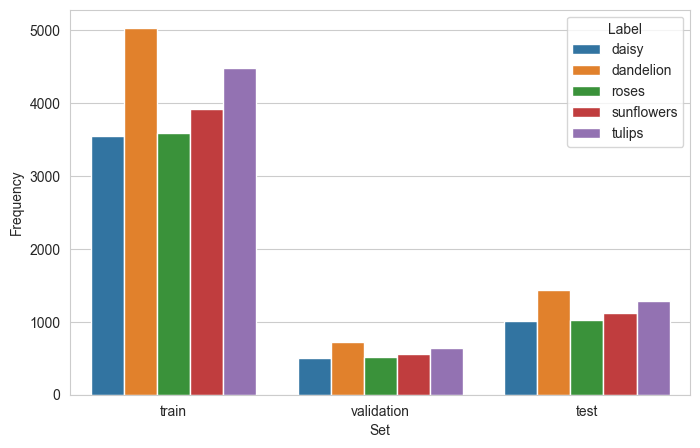

In [20]:
distribution_between_sets(image_dirs = 'inputs/dataset/raw/flower_photos')

## **Color difference between images**


This function iterates through all the images in the "train" folder to analyze the color differences between them.<br>



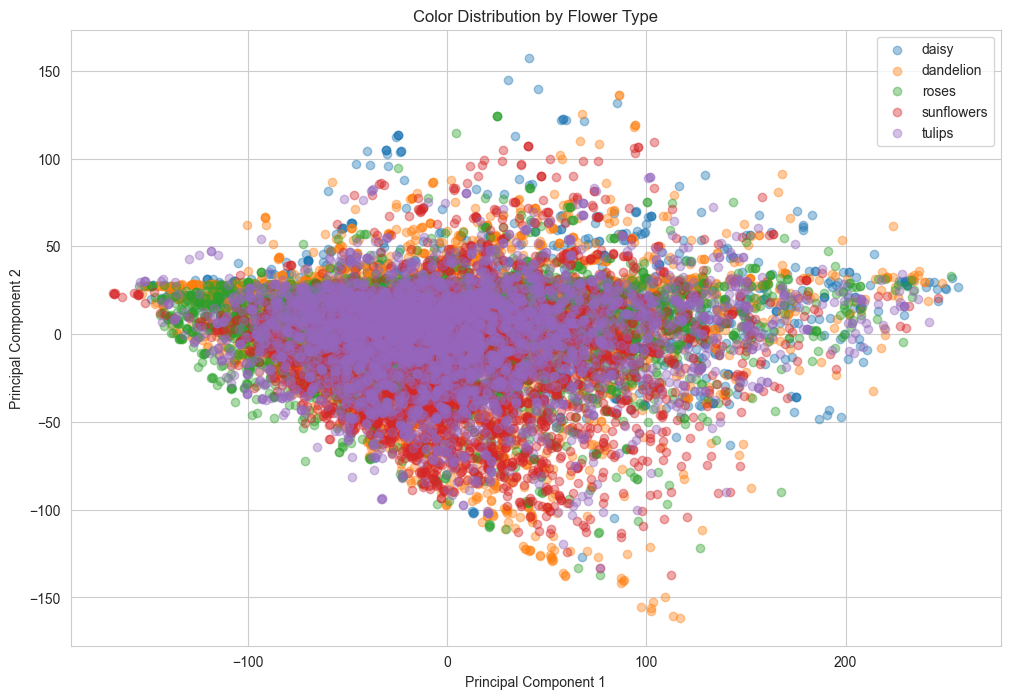

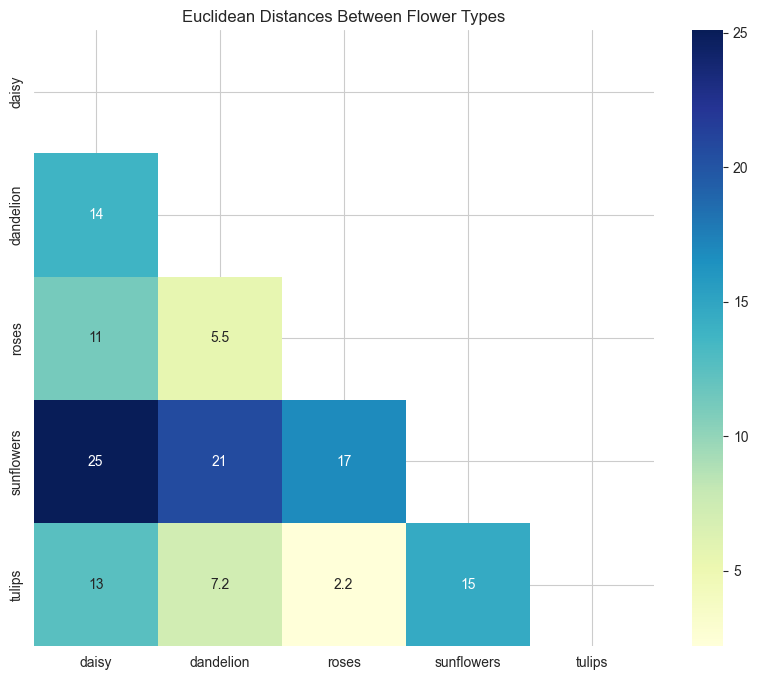

In [24]:

image_dirs = ['inputs/dataset/raw/flower_photos/train']

# Initialize an empty dictionary to store flower categories and their image paths
flower_paths = {}

# Iterates through all subfolders in train folder
for dir_path in image_dirs:
    for folder in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, folder)
        if os.path.isdir(folder_path):
            if folder in flower_paths:
                flower_paths[folder].extend(glob.glob(os.path.join(folder_path, "*.jpg")))
            else:
                flower_paths[folder] = glob.glob(os.path.join(folder_path, "*.jpg"))
                

def color_pca_scatter_with_similarity(flower_paths):
    """
    This function analyzes and visualizes the color distribution of flowers in a dataset 
    by using Principal Component Analysis (PCA) for dimensionality reduction and calculating 
    the similarity between flower types based on their average color.

    The function performs the following tasks:
    1. Reads the images for each flower type and computes the average color for each image.
    2. Applies PCA to reduce the color features to two principal components (PC1, PC2).
    3. Creates a scatterplot of the flowers based on the PCA components to visualize the color distribution.
    4. Calculates the Euclidean distance between the mean PCA values of each flower type to determine their similarity.
    5. Creates and displays a heatmap of the similarity (distance) between the flower types.

    Parameters:
    - flower_paths (dict): A dictionary where the keys are flower names and the values are lists of file paths 
                            to the images of that flower.

    Returns:
    - Scatterplot and heatmap images saved to disk showing the color distribution and similarity between flower types.
    """
    
    colors = []
    labels = []
    
    # gathers colors and labels
    for flower, paths in flower_paths.items():
        for path in paths:
            img = cv2.imread(path)
            if img is not None:
                avg_color = img.mean(axis=(0, 1))  
                colors.append(avg_color)
                labels.append(flower)
    
    # converts to PCA to reduce dimensions
    pca = PCA(n_components=2)
    colors_pca = pca.fit_transform(colors)
    colors_df = pd.DataFrame(colors_pca, columns=["PC1", "PC2"])
    colors_df['flower'] = labels
    
    # Creates scatterplot
    plt.figure(figsize=(12, 8))
    for flower in colors_df['flower'].unique():
        subset = colors_df[colors_df['flower'] == flower]
        plt.scatter(subset['PC1'], subset['PC2'], label=flower, alpha=0.4)
    plt.legend()
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Color Distribution by Flower Type")
    
    # Saves the scatterplot
    plt.savefig(f'{file_path}/color_distribution_by_flower_type.png', dpi=300)
    plt.show()  
    
    # Calculates the mean value for PC1 and PC2 
    mean_pc = colors_df.groupby('flower')[['PC1', 'PC2']].mean()
    
    # Calculates the similarity (distance) between every flower category
    distance_matrix = euclidean_distances(mean_pc)
    
    # Deletes the upper half (mirror image)
    mask = np.triu(np.ones_like(distance_matrix, dtype=bool))  
    distance_matrix[mask] = np.nan  
    
    # Creates a heatmap over the similarities
    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=True, cmap='YlGnBu', xticklabels=mean_pc.index, yticklabels=mean_pc.index, mask=mask)
    plt.title("Euclidean Distances Between Flower Types")
    
    # Saves the heatmap
    plt.savefig(f'{file_path}/flower_similarity_heatmap.png', dpi=300)
    plt.show()  


color_pca_scatter_with_similarity(flower_paths)

A higher score indicates that the colors are more similar, while a lower score suggests significant color differences.